# Collaboration and Competition

This notebook presents the solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program, using a multi-agent policy gradient method. The target is to train a 2 arm robot to reach and follow a moving target.

You choose to train or to test by setting the variable `what_to_do` to the corresponding string. Note that during training, the graphics is turned off to make the simulation faster. 


In [1]:
what_to_do = '' # set it to 'train' or 'test'
what_to_do = 'test'
what_to_do = 'train'


### 1. Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

I am running on Windows and the simulator is located in a directory called `Reacher_Windows_x86_64` in the same directory as the notebook. Consequently, my file name will be 

```
file_name="./Tennis_Windows_x86_64/Tennis.exe"
```

Also, the flag `no_graphics` allows to turn off the graphics and have a little bit faster execution.

```
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)
```

In [3]:
if (what_to_do == 'train'):
    env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)
else:
    env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=False)
    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training

We are now ready to start the training. We have to set the environment with `train_mode` set to `True`.

```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Model

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """
        Actor (Policy) Model. A simple 2 layer fully connected network.
    
    """

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """Reset the parameters and initialize the weights."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """
        Critic (Value) Model. The input is both the current state and the actions.
        State gors through a first layer and then will be concatenated with the action
        before going through the output layer to estimate the corresponding value.
        
    """

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """Reset the parameters and initialize the weights."""
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [8]:
#ddgp_agent
import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

import os


class DDGPAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, agent_config, random_seed, memory):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = agent_config["state_size"]
        self.action_size = agent_config["action_size"]
        self.batch_size = agent_config["batch_size"]
        self.lr_actor = agent_config["lr_actor"]
        self.lr_critic = agent_config["lr_critic"]
        self.buffer_size = agent_config["buffer_size"]
        self.noise_decay = agent_config["noise_decay"]
        self.gamma = agent_config["gamma"]
        self.tau = agent_config["tau"]
        self.learn_every = agent_config["learn_every"]
        self.device = agent_config["device"]
        self.step_counter = 0
        
        self.seed = random.seed(random_seed)
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, random_seed).to(self.device)
        self.actor_target = Actor(self.state_size, action_size, random_seed*2).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local  = Critic(state_size, action_size, random_seed*3).to(self.device)
        self.critic_target = Critic(state_size, action_size, random_seed*4).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr_critic)
        
        # Noise process
        self.noise = OUNoise(self.action_size, random_seed)
        
        # Noise ampliture
        self.noise_amplitude = 1.0
        
        # Replay memory
        self.memory = memory
        self.short_memory = deque(maxlen=100)       # Saves statistics about the 10 last inputs
            
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        if ((sum(self.short_memory) > 0) or (reward > 0)):
            self.short_memory.append(1 if reward > 0 else 0)
            self.memory.add(state, action, reward, next_state, done)
            
        # Learn, if enough samples are available in memory    
        if len(self.memory) > self.batch_size:
            self.step_counter = (self.step_counter + 1) % self.learn_every
            if (self.step_counter == 0):
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma, self.tau)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()*self.noise_amplitude
            self.noise_amplitude *= self.noise_decay
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()                               
        
    def learn(self, experiences, gamma, tau):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, tau)
        self.soft_update(self.actor_local, self.actor_target, tau)   
      
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def save_graphs(self, pre_name):
        """
            Save the graphs in the same directory as the notebook.
        """
        torch.save(self.actor_local.state_dict(), pre_name + 'checkpoint_actor.pth')
        torch.save(self.critic_local.state_dict(), pre_name + 'checkpoint_critic.pth')

            
    def load_graphs(self, pre_name):
        """
            Load the graphs if there are in the same directory as the notebook.
        """
        if (os.path.isfile(pre_name + 'checkpoint_actor.pth') and os.path.isfile(pre_name + 'checkpoint_critic.pth')):
            self.actor_local.load_state_dict(torch.load(pre_name + 'checkpoint_actor.pth'))
            self.critic_local.load_state_dict(torch.load(pre_name + 'checkpoint_critic.pth'))

In [9]:
# Memory
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, device, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
# OUNoise.py
import numpy as np
import torch

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [11]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network

#from ddpg import DDPGAgent
import torch

class MADDPGAgent():
    def __init__(self, AgentConfig, shared_memory=True):
        super(MADDPGAgent, self).__init__()

        if torch.cuda.is_available():
            print("--- Using GPU ---")
        else:
            print("--- Using CPU ---")
         
        if (shared_memory):
            memory = ReplayBuffer(AgentConfig["action_size"], AgentConfig["buffer_size"], 
                                   AgentConfig["batch_size"], AgentConfig["device"], AgentConfig["random_seed"])
            self.memory = [memory,memory]
        else:
            memory0 = ReplayBuffer(AgentConfig["action_size"], AgentConfig["buffer_size"], 
                                   AgentConfig["batch_size"], AgentConfig["device"], AgentConfig["random_seed"])
            memory1 = ReplayBuffer(AgentConfig["action_size"], AgentConfig["buffer_size"], 
                                   AgentConfig["batch_size"], AgentConfig["device"], AgentConfig["random_seed"])
            self.memory = [memory0,memory1]

        self.maddpg_agent = [DDGPAgent(AgentConfig, AgentConfig["random_seed"], self.memory[0]), 
                             DDGPAgent(AgentConfig, AgentConfig["random_seed"], self.memory[1])]
        
        self.gamma = AgentConfig["gamma"]

    def act(self, obs_all_agents, add_noise=True):
        """get actions from all agents in the MADDPG object"""
        actions = []#[agent.act(obs.astype(np.double), add_noise=add_noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        for i in range(len(self.maddpg_agent)):
            actions += [self.maddpg_agent[i].act(obs_all_agents[i].astype(np.double), add_noise=add_noise)]
        return actions

    def step(self, states, actions, rewards, next_states, dones):
        """take step for all agents in the MADDPG object"""
        for i in range(len(self.maddpg_agent)):
            self.maddpg_agent[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i])

    def reset(self):
        """reset all agents in the MADDPG object"""
        for agent in self.maddpg_agent:
            agent.reset()
            
    def save_graphs(self, pre_name):
        """save graphs for all agents in the MADDPG"""
        for i in range(len(self.maddpg_agent)):
            self.maddpg_agent[i].save_graphs(pre_name + str(i+1) + '_')
            
    def load_graphs(self, pre_name):
        """load graphs for all agents in the MADDPG"""
        for i in range(len(self.maddpg_agent)):
            self.maddpg_agent[i].load_graphs(pre_name + str(i+1) + '_')

### 3. Training or testing

We are now ready to start the training. For training, we have to set the environment with `trainin_mode` set to `True`.

```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [12]:
def RL_iterate(agent, env, n_episodes=2000, max_t=2000, pre_name=''):
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores = []
    max_score = -np.Inf
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment   
        agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)

            states = next_states                               # roll over states to next time step
            score += rewards
            
            if np.any(dones):
                break

        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        average_scores.append(np.mean(scores_deque))

        print('\rEpisode {}\tScore: {:.3f}\tAverage 100 Score: {:.3f}\tmemory length: {}'.format(
            i_episode, np.max(score), np.mean(scores_deque), len(agent.maddpg_agent[0].memory)), end="")
        if i_episode % 100 == 0:
            agent.save_graphs(pre_name)
            print('\rEpisode {}\tAverage 100 Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            if (np.mean(scores_deque) >= 0.5):
                break
    return [scores,average_scores]

def RL_test(agent, env, n_episodes=100, max_t=2000, pre_name=''):
    agent.load_graphs(pre_name)
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores = []
    max_score = -np.Inf
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   
        agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=False)
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            states = next_states                               # roll over states to next time step
            score += rewards
            
            if np.any(dones):
                break

        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        average_scores.append(np.mean(scores_deque))

        print('\rEpisode {}\tScore: {:.3f}\tAverage 100 Score: {:.3f}'.format(i_episode, np.max(score), np.mean(scores_deque)), end="")
    return [scores,average_scores]


--- Using GPU ---
Training starts with graphics off...
Episode 0	Average 100 Score: 0.000 Score: 0.000	memory length: 0
Episode 100	Average 100 Score: 0.010 Score: 0.006	memory length: 534
Episode 200	Average 100 Score: 0.000 Score: 0.002	memory length: 837
Episode 300	Average 100 Score: 0.010 Score: 0.006	memory length: 1474
Episode 400	Average 100 Score: 0.010 Score: 0.011	memory length: 2530
Episode 500	Average 100 Score: 0.000 Score: 0.004	memory length: 2950
Episode 600	Average 100 Score: 0.000 Score: 0.000	memory length: 2950
Episode 700	Average 100 Score: 0.000 Score: 0.000	memory length: 2950
Episode 800	Average 100 Score: 0.000 Score: 0.000	memory length: 2950
Episode 900	Average 100 Score: 0.000 Score: 0.001	memory length: 3051
Episode 1000	Average 100 Score: 0.000 Score: 0.003	memory length: 3354
Episode 1100	Average 100 Score: 0.010 Score: 0.013	memory length: 4687
Episode 1200	Average 100 Score: 0.020 Score: 0.025	memory length: 6963
Episode 1300	Average 100 Score: 0.030 S

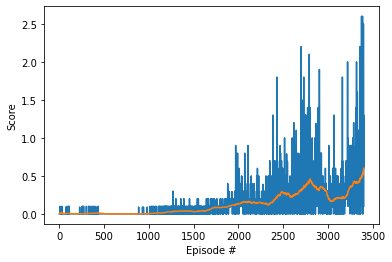

In [13]:
AgentConfig={"state_size": state_size, 
             "action_size": action_size, 
             "lr_actor": 1e-3,         # learning rate of the actor
             "lr_critic": 1e-3,        # learning rate of the critic 
             "batch_size": 512,        # minibatch size
             "buffer_size": int(1e5),  # replay buffer size 
             "gamma": 0.99,            # discount factor
             "noise_decay": 1,         # Noise decay rate - Added, but not used
             "tau": 1e-3,              # for soft update of target parameters
             "random_seed": 13,        # Random Seed
             "learn_every": 2,        # frequency of learning
             "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")}

#from ddpg_agent import Agent
agent = MADDPGAgent(AgentConfig, shared_memory=True)

if what_to_do == 'train':
    print("Training starts with graphics off...")
    scores = RL_iterate(agent, env, n_episodes=5000, pre_name='selective_maddpg_')
else:
    print("Testing starts with graphics on...")
    scores = RL_iterate(agent, env, n_episodes=100, pre_name='selective_maddpg_')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[0])+1), scores[0],np.arange(1, len(scores[0])+1), scores[1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
   
env.close()